## Image Classification of Cats and Dogs using CNN

## 1. Introduction
This project aims to build a deep learning-based image classifier to distinguish between images of cats and dogs using Convolutional Neural Networks (CNNs). Utilize a labeled dataset of pet images and train a neural network from scratch or using transfer learning, CNN architecture (Conv, Pooling, Flatten, Dense), Data augmentation, Accuracy/loss curves and model validation

## 2. Dataset Preparation
The following code downloads the dataset using Kaggle API, unzips it, and splits images into training and validation sets \.


In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Saving kaggle.json to kaggle.json


In [9]:

!kaggle competitions download -c dogs-vs-cats


!unzip -q dogs-vs-cats.zip -d dataset
!unzip -q dataset/train.zip -d dataset




dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
!kaggle datasets download -d humansintheloop/dollar-street-dataset
!unzip -q dollar-street-dataset.zip -d dollar_street


Dataset URL: https://www.kaggle.com/datasets/humansintheloop/dollar-street-dataset
License(s): CC0-1.0
100% 3.26G/3.27G [01:57<00:00, 221MB/s]
100% 3.27G/3.27G [01:57<00:00, 30.0MB/s]


In [10]:
import os

correct_path = "dataset/train"
if os.path.exists(correct_path):
    images = os.listdir(correct_path)
    print(f"Images found actually: {len(images)}")
    print("Sample:", images[:5])
else:
    print("dataset/train not found.")



Images found actually: 25001
Sample: ['cat.2870.jpg', 'cat.9940.jpg', 'dog.8601.jpg', 'dog.2332.jpg', 'cat.1194.jpg']


In [13]:
import os

for root, dirs, files in os.walk("dollar_street"):
    print(root)
    break


dollar_street


In [14]:
import os

print(os.listdir("dollar_street"))


['Dollar street trial']


In [15]:
print(os.listdir("dollar_street/Dollar street trial"))


['Abstract__things-i-dream-of-having', 'Objects__bikes', 'Objects__diapers', 'Objects__pets', 'Objects__jackets', 'Objects__fruit-trees', 'Objects__tooth-paste', 'Objects__beds', 'Objects__front-doors', 'Objects__dish-brushes', 'Objects__chickens', 'Objects__guest-beds', 'Objects__nicest-shoes', 'Objects__kids-bed', 'Abstract__get-water', 'Abstract__sources-of-heat', 'Objects__family-snapshots', 'Objects__social-drinks', 'Abstract__next-big-things-i-plan-to-buy', 'Objects__water-outlets', 'Objects__power-outlets', 'Places__bathrooms', 'Places__kitchens', 'Objects__soaps', 'Places__child-rooms', 'Places__work-areas', 'Objects__toys', 'Places__hallways', 'Objects__ovens', 'Objects__papers', 'Objects__grains', 'Places__agriculture-land', 'meta.json', 'Objects__phones', 'Objects__roofs', 'Objects__cooking-pots', 'Objects__wardrobes', 'Objects__palms', 'Objects__menstruation-pads', 'Objects__lock-on-front-doors', 'Places__drying-clothes', 'Objects__light-sources', 'Objects__goats', 'Abstrac

## 3. Dataset Organization & Splitting
The dataset was manually divided into train and validation sets with separate folders for cats and dogs, preparing it for model training.

In [16]:
import os, shutil, random

original_dir = 'dataset/train'
others_dir = "dollar_street/Dollar street trial"

base_dir = 'dataset/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

folders = [
    os.path.join(train_dir, 'cats'),
    os.path.join(train_dir, 'dogs'),
    os.path.join(train_dir, 'others'),
    os.path.join(val_dir, 'cats'),
    os.path.join(val_dir, 'dogs'),
    os.path.join(val_dir, 'others')
]

shutil.rmtree(base_dir, ignore_errors=True)
for folder in folders:
    os.makedirs(folder)

cats = [f for f in os.listdir(original_dir) if f.startswith('cat')]
random.shuffle(cats)
for i in range(800):
    shutil.copy(os.path.join(original_dir, cats[i]), folders[0])
for i in range(800, 1000):
    shutil.copy(os.path.join(original_dir, cats[i]), folders[3])

dogs = [f for f in os.listdir(original_dir) if f.startswith('dog')]
random.shuffle(dogs)
for i in range(800):
    shutil.copy(os.path.join(original_dir, dogs[i]), folders[1])
for i in range(800, 1000):
    shutil.copy(os.path.join(original_dir, dogs[i]), folders[4])

others = []
for subdir, _, files in os.walk(others_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            others.append(os.path.join(subdir, file))

random.shuffle(others)
for i in range(200):
    shutil.copy(others[i], folders[2])
for i in range(200, 300):
    shutil.copy(others[i], folders[5])

print("✅ All 3 classes copied successfully!")


✅ All 3 classes copied successfully!


## 4. Data Augmentation
To improve model robustness, data augmentation techniques like rotation, zoom, shear, and horizontal flipping are applied during training.


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1800 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


## 5. CNN Model Architecture
A custom CNN is built with multiple convolutional and max-pooling layers, followed by dense layers and dropout to prevent overfitting.


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 6. Model Training
The model is trained for 10 epochs with early stopping. Below is the training and validation accuracy and loss.


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_best_3class.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7873 - loss: 0.6402

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 582ms/step - accuracy: 0.7889 - loss: 0.6355 - val_accuracy: 0.9720 - val_loss: 0.1142
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.9564 - loss: 0.1273 - val_accuracy: 0.9660 - val_loss: 0.1003
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - accuracy: 0.9696 - loss: 0.0863 - val_accuracy: 0.9700 - val_loss: 0.1075
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.9693 - loss: 0.0800 - val_accuracy: 0.9720 - val_loss: 0.0972
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.9715 - loss: 0.0824 - val_accuracy: 0.9740 - val_loss: 0.0886
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - accuracy: 0.9784 - loss: 0.0594 - val_accuracy: 0.9700 - val_loss: 0.0861
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step - accuracy: 0.9788 - loss: 0.0475 - val_accuracy: 0.9720 - val_loss: 0.0975
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.9808 - loss: 0.0558 - val_accuracy: 0.976

## 7. Training and Validation Performance
The following plots show how training/validation accuracy and loss evolved over epochs.


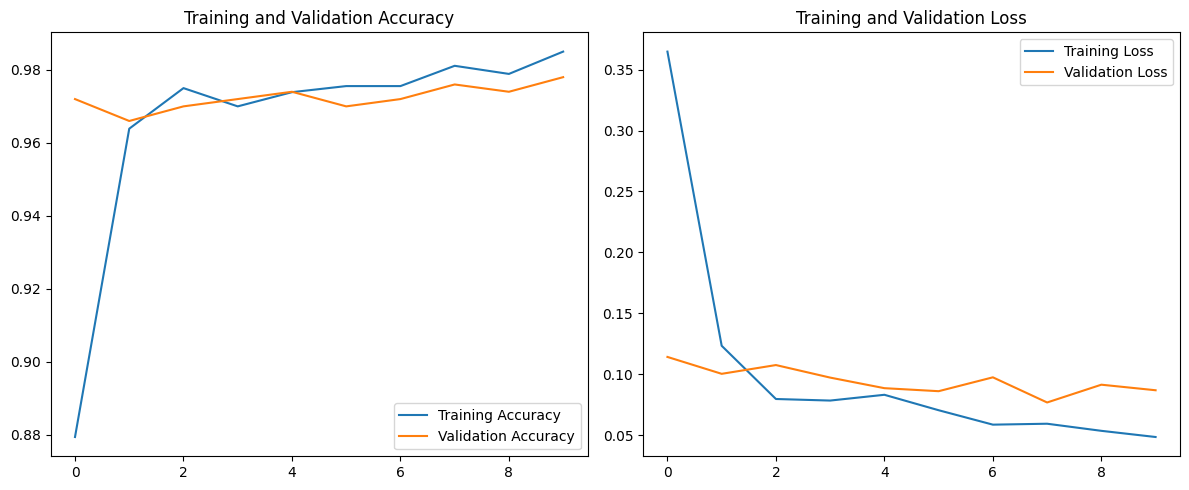

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## 8. Sample Prediction
Here is a test prediction using a single image and the trained model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


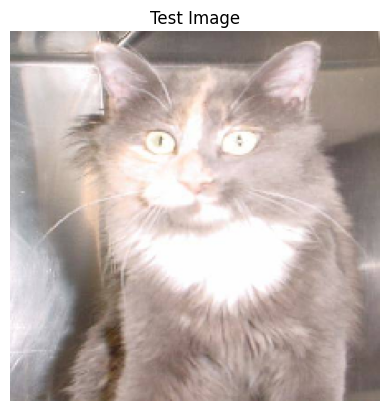

✅ Prediction: Cat 🐱


In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = 'dataset/train/train/cat.2870.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

try:
    prediction = model.predict(img_array)

    plt.imshow(img)
    plt.title("Test Image")
    plt.axis("off")
    plt.show()

    class_names = ['Cat 🐱', 'Dog 🐶', 'Others 👽']
    pred_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100

    print(f"✅ Prediction: {class_names[pred_class]}")

except Exception as e:
    print("❌ Error while predicting image:", e)


## 9. Model Saving
The trained model is saved in native `.keras` format for future use or deployment.


In [23]:
model.save("model.keras")

In [24]:
from google.colab import files
files.download("model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10. Conclusion
A custom CNN was developed and trained from scratch to achieve ~98% training accuracy and ~97% validation accuracy. The model successfully distinguishes between cats and dogs.

### Acknowledgment

I would like to express my heartfelt gratitude to **Mr. Anand Maurya**, my mentor from **IBM**, under whose expert guidance and continuous support this project was successfully completed.

As a participant in the **IBM PBEL (Project-Based Experiential Learning) Program**, I had the opportunity to work on a real-world machine learning problem using deep learning techniques. Throughout the journey, Anand Maurya Sir not only provided technical assistance but also motivated me to think critically, solve problems independently, and improve my skills with each step.

His approachable nature, detailed feedback, and constant encouragement made this learning experience both meaningful and enjoyable. The PBEL program played a vital role in enhancing my understanding of AI/ML and gave me the confidence to implement practical solutions using Convolutional Neural Networks.

I sincerely thank **IBM and the entire PBEL program team** for creating such a valuable learning platform.
